# RTC 2019 MATLAB Volatility Trading Case

## Overview
We know that there are three opportunities to trade on;
- Mispricing between specific options with respect to other option
    - Put Call Parity Algorithm
- Mispricing of options with respect to the underlying
    - Skew Trading Algorithm - incorrect implied volatility value for forecast realized vol
- Mispricing of all of the options with respect to the underlying
    - The Underlying is taken incorrectly in the BSM model

We will examine all of these cases but there are some underlying tools that we will need

## Formulae Derivation

### Underlying Equity - Itô Process
We know that the dynamic of an equity generally can be taken to be a Geometric Brownian Motion or an Itô Process;

$$dS_t = \mu S dt + \sigma S dW_t$$
 
$$\text{Where} ~ \mu = \text{drift rate} , \sigma =\text{vol}$$

$$dW_t  \text{is a Wiener Process meaning that} ~ dW_t \sim \mathcal{N}(0,1)$$

In this case

$$P_{RTM,t} = P_{t-1} (1 + r_t) ~ \text{r is a weiner process} ~ r_t \sim \mathcal{N}(0,\sigma^2) ~ \text{$\mu$ = 0 and $\sigma$ = 20}$$

Which implies that P has no drift rate as it is just the previous price + some random return drawn from the normal distribution with mean = 0 so it has no directional inclination

$$P_{RTM,t} = P_{t-1} + P_{t-1} r_t$$

this condition of no drift rate means that our strategy should never incorporate any directional inclination as clearly the price dynamic is completely random with no drift rate. This is also true of implied vol, meaning that the implied vol should always reflect the realised vol as with no drift rate there is no way to successfully directionally forecast volatility.

It is worth noting this dynamic property makes it suitable to price options on using the Black Scholes Merton

### Derivative on Underlying Equity - Itô's Lemma
We are told that the market maker will price the options using the Black Scholes Model but that there will be mispricings. In order to take advantage of these mispricings we will have to price the options using the Black Scholes model ourselves correctly in order to find any pricing discrepancies.

- We have just shown that an equity is taken to be an Itô Process, and given this information we can assume that an option follows Itö's Lemma as it's price is a function of the underlying. This means that it will follow;

$$\text{Taking the option price to be} ~ f(x)$$

$$\text{The dynamic of the option will follow} : df = (\frac{\partial f}{\partial t} + \mu S \frac{\partial f}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2})dt + \sigma S \frac{\partial f}{\partial S} dW$$

### Black Scholes Merton Model
In order to derive the Black Scholes option pricing model from Itô's Lemma we must construct a theoretical portfolio;
- 1 Long Call (f)
- df/dS Short Underlying (S)

$$\text{This makes our portfolio equal to} P = f - \frac{\partial f}{\partial S} S$$

$$\text{Hence the dynamic of our portfolio is} \partial P = \partial f - \frac{\partial f}{\partial S} \partial S$$

$$\text{But we Already know that the dynmaic of dS is equal to} dS_t = \mu S dt + \sigma S dW_t \text{and the dynamic of df is equal to} ~ df = (\frac{\partial f}{\partial t} + \mu S \frac{\partial f}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2})dt + \sigma S \frac{\partial f}{\partial S} dW$$

$$\text{Hence the dynamic of the portfolio is equal to} ~ dP = (\frac{\partial f}{\partial t} + \mu S \frac{\partial f}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2} - \frac{\partial f}{\partial S} \mu S)dt + \sigma S ( \frac{\partial f}{\partial S} - \frac{\partial f}{\partial S} ) dW$$

$$dP = (\frac{\partial f}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2} ) dt$$

Now since there is no dWt term there is no Weiner process component there is no risk and we can see that the delta of the portfolio is equal to 0. Since it is now risk - free we can now represent it's growth as;

$$dP = rPdt = r(f - \frac{\partial f}{\partial S} S) dt$$

Setting these two equations equal to eachother we get;

$$(\frac{\partial f}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2} ) dt = r(f - \frac{\partial f}{\partial S} S) dt$$

$$\frac{\partial f}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2}  = rf - rS \frac{\partial f}{\partial S}$$

$$\frac{\partial f}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial f^2}{\partial S^2} + rS \frac{\partial f}{\partial S}  = rf$$

$$\text{Now we have arrived at the Black Scholes PDE}$$

$$\text{We can see in the case that} ~ P_{RTM,t} = P_{t-1} (1 + r_t) ~ \text{where r is a weiner process} ~ r_t \sim \mathcal{N}(0,\sigma^2) ~ \text{where $\mu$ = 0 and $\sigma$ = 20}$$

Which implies that P has no drift rate as it is just the previous price + some random return drawn from the normal distribution with mean = 0

$$\text{so it has no directional inclination} ~ P_{RTM,t} = P_{t-1} + P_{t-1} r_t ~ \text{making it suitable to price options on using the Black Scholes Merton}$$

It is also worth noting here that this condition means that our strategy should never incorporate any directional inclination as clearly the price dynamic is completely random with no drift rate

From the BSM Model we can derive the following pricing formulae

$$C = S_t N(d_1) - K e ^{-e (T-t)} N(d_2)$$

$$P = K e ^{-e (T-t)} N(-d_2) - S_t N(-d_1)$$

where

$$d_1 = \frac{ln \frac{S_t}{K} + ( r + \frac{\sigma^2}{2} ) (T-t)}{\sigma \sqrt{T-t}}$$

$$d_2 = d_1 - \sigma \sqrt{T-t}$$

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as si
import sympy as sy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings; warnings.simplefilter('ignore')

## Analytical Option Pricer

In [5]:
def vanilla(S, K, T, r, sigma, option = 'call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    return result

In [7]:
sigma = 0.2
r = 0
T = 1
S = 50
K = 54
vanilla(S, K, T, r, sigma,'call')

2.4438422919289025

Ofcourse we are very interested in the efficiency of our code so it may be optimal to use numerical methods such as Monte Carlo Methods to simulate our pricing

## Monte Carlo Methods Option Pricer

In [5]:
#n defines the time step, can't be > 365 if we only observe share price once per week
#nr = defines the number of simulations
#cp = + 1 for call / -1 for put
#dt = T/n time step length

def MonteCarloPricer(S,cp,K):
    nu = r - 0.5 * sigma **2
    S_val = np.zeros((nr, n+1)) #define results matrix
    rand = np.random.randn(nr,n)
    S_val[:,0] = S
    for i in range(nr): #start from 0 to nr so if nr times is 1000 then final entry will be 999
        for j in range(1,n+1): #range starting from 1 not 0 because need to use first j-1 column to begin iteration
            S_val[i,j] = S_val[i,j-1] * np.exp(nu*dt + sigma * dt**0.5 * rand[i, j-1])
            
    FinPayOff = np.maximum(cp*(S_val[:,-1] - K),0) #maximum per each simulation, compare each step with 0
    
    PDisc = np.exp( -r * T) * FinPayOff #payoff discounted to PV
    price = PDisc.mean() #average of all of the discounted simulations
    std = np.std(PDisc) #stdev of all of the discounted simulations
    
    #plot
    plt.figure
    for i in range(nr):
        plt.plot(S_val[i,:])
        plt.title('Monte Carlo Method simulations - GBM Paths')
    plt.show()
    return print("Price:",price,"Stdev:",std)
    
    #print('The price of the Monte Carlo Method with',nr,'simulation is %.5f.' % price)
    #print('The standard deviation is %.5f.' % std)

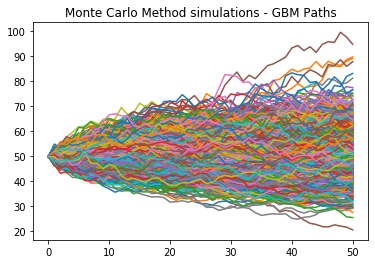

Price: 2.411511997887289 Stdev: 5.116532692603589


In [6]:
sigma = 0.2
r = 0
T = 1
S = 50
K = 54
n = 50
nr = 1000
cp = 1
dt = T/n

#This should provide a price similar to our analytical value above

MonteCarloPricer(S,cp,K)

## First and foremost We build a data frame to store the market prices to utilize in our trading algorithms

It is important to note that this will be our data would feed into. For now I have filled the data frame with the starting option prices from the case study.

I am making use of the pandas library and this will make it easier for us to call on these data points within our trading algorithms

In [7]:
S = 50
K = {'Numerical_K':[45,46,47,48,49,50,51,52,53,54],'K/S':[45/S,46/S,47/S,48/S,49/S,50/S,51/S,52/S,53/S,54/S],
     'Call_P':[5.04,4.09,3.20,2.40,1.71,1.15,0.73,0.44,0.24,0.13],'Put_P':[0.04,0.09,0.20,0.40,0.71,1.15,1.73,2.44,3.24,4.13]}
df = pd.DataFrame(data=K)
df

,Numerical_K,K/S,Call_P,Put_P
0,45,0.90,5.04,0.04
1,46,0.92,4.09,0.09
2,47,0.94,3.20,0.20
3,48,0.96,2.40,0.40
4,49,0.98,1.71,0.71
5,50,1.00,1.15,1.15
6,51,1.02,0.73,1.73
7,52,1.04,0.44,2.44
8,53,1.06,0.24,3.24
9,54,1.08,0.13,4.13


## Strategies ~ Trading Algorithms

### Mispricing between specific options with respect to other option
There should be no delta bias in an option's price, we can take its price to be purely a function of its volatility.

Given we have been told that there will be mispricings of options relative to eachother we can assume there will be discrepancies in the implied volatility for given set strikes as these are the only options one can establish a mispricing because for a given strike the implied volatility should be consistent through puts and calls.

- I want to produce skew curves for both the puts and calls and from these
    - Whenever put skew curve is below call skew curve
        - Buy Put Options in this region as good value as vol is underpriced
        - Sell Call Options in this region as they are poor value as vol is overpriced

    - Whenever put skew curve is above call skew curve
        - Buy Call Options in this region as good value as vol is underpriced
        - Sell Call Options in this region as they are poor value as vol is overpriced
        
We could also incorporate this strategy on an individual level using the Put Call parity which is of the form

$$c + K e^{rT} = p + S_0$$

This is derived from the following identities

$$\text{The call option can never be worth more than the stock and never less than it's current intrinsic value}$$

$$S_0 - Ke^{-rT}  \leq c \leq S_0$$

$$\text{The put must be worth less than or equal to it's maximum possible payout $Ke^{-rT}$ and greater than it's current intrinsic value}$$

$$Ke^{-rT} - S_0 \geq p \geq ke^{-rT}$$

In [8]:
#Specific Option Mispricing Strategy

def specific_option_misprice(df):
    
    for i in range(len(df)-1):
        
        if df["Call_P"][i] > df["Put_P"][i] + S - df["Numerical_K"][i]*np.exp(-r*T):
            
            print("At Strike",df["Numerical_K"][i],"Buy Put, Sell Call")
            
        elif df["Call_P"][i] < df["Put_P"][i] + S - df["Numerical_K"][i]*np.exp(-r*T):
            
            print("At Strike",df["Numerical_K"][i],"Buy Call, Sell Put")

In [9]:
specific_option_misprice(df)

At Strike 45 Buy Put, Sell Call
At Strike 46 Buy Call, Sell Put
At Strike 47 Buy Call, Sell Put
At Strike 48 Buy Put, Sell Call
At Strike 49 Buy Call, Sell Put
At Strike 50 Buy Put, Sell Call
At Strike 51 Buy Put, Sell Call
At Strike 52 Buy Put, Sell Call
At Strike 53 Buy Call, Sell Put


## Mispricing between all of the options with respect to the underlying

We already know that the market makers are going to misprice all of the options with repect to their correct implied volatility given the news release forecast of volatility so this will present an opportunity to trade the skew of the puts and calls

To create an algorithm with inequalities in implied volatility and realized volatility we first must find implied volatility (there will never be any forward forcasting bias in this because the underlying is a wiener process)

In order to extract the implied volatility from the option prices we will need to use numerical methods since the Black Scholes Model is a partial differential equation which can't be solved Efficiently analytically

I will use Newton-Raphson algorithm to extract implied volatility which is based on the following principle

$$ y=f'(x_{n})\,(x-x_{n})+f(x_{n})\ $$

$$\text{The function is satisfied when} {\displaystyle (x,y)=(x_{n+1},0)}$$

$$ 0=f'(x_{n})\,(x_{n+1}-x_{n})+f(x_{n})\ $$

$$ x_{n+1}=x_{n}-{\frac {f(x_{n})}{f'(x_{n})}}\ $$

Since we are dealing with implied volatilities, we can write it using σ

$$σ_{imp}^{k+1}=σ_{imp}−\frac{f(σ_{imp}^k)}{f′(σ_{imp}^k)},∀k≥0$$

With

$$f(x)=S^{e−qT} N(d_1(x))−Ke^{−rT}N(d_2(x))− C ~ \text{and} ~ f′(x)=\frac{1}{\sqrt{2π}} Se^{−qT}\sqrt{T} e^{\frac{-d1(x)}{2}}$$

### Note here how our sigma here is different to in our option pricing model. The sigma here will represent the news release forecast of the upcoming realized vol. Previously sigma represented the volatility of the Wiener process in the Itô process of the dynamic of the underlying

In [10]:
def vega(S, K, T, r, sigma):

    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    vega = S * si.norm.cdf(d1, 0.0, 1.0) * np.sqrt(T)
    
    return vega

Newton - Raphson Implied Volatility Calculator

In [11]:
def nr_imp_vol(S, K, T, f, r, sigma, option = 'call'):   
    #S: spot price
    #K: strike price
    #T: time to maturity
    #f: Option value
    #r: interest rate
    #sigma: volatility of underlying asset
    #option: where it is a call or a put option
    
    d1 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        fx = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0) - f
        vega = (1 / np.sqrt(2 * np.pi)) * S * np.sqrt(T) * np.exp(-(si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
        
    if option == 'put':
        fx = K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0) - f
        vega = (1 / np.sqrt(2 * np.pi)) * S * np.sqrt(T) * np.exp(-(si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
    tolerance = 0.000001 #limit of margin accepted for newton raphson algorithm
    x0 = sigma #we take our known 
    xnew  = x0
    xold = x0 - 1
        
    while abs(xnew - xold) > tolerance:
    
        xold = xnew
        xnew = (xnew - fx - f) / vega
        
        return abs(xnew)

In [13]:
sigma = 0.2
r = 0
T = 1
S = 50
K = 50
f = df["Call_P"][5]
option = "call"

nr_imp_vol(S, K, T, f, r, sigma, option = 'call')

0.011146350155415733

Now we are ready to implement a vol mispricing algorithm using the newton raphson infrastructure we have built

## Skew Trading Algorithm

Given we have been told that there will be mispricings of options relative to eachother we can assume there will be discrepancies in the implied volatility for given set strikes as these are the only options one can establish a mispricing because for a given strike the implied volatility should be consistent through puts and calls.

- I want to produce skew curves for both the puts and calls and from these
    - Whenever put skew curve is below call skew curve
        - Buy Put Options in this region as good value as vol is underpriced
        - Sell Call Options in this region as they are poor value as vol is overpriced

    - Whenever put skew curve is above call skew curve
        - Buy Call Options in this region as good value as vol is underpriced
        - Sell Call Options in this region as they are poor value as vol is overpriced

In order to maintain within our strict delta limitations the strategy will systematically buy straddles at strikes where the implied vol is under priced and systematically sell vol at strikes where the vol is over priced

In [14]:
S = 50 #market price
sigma_release = 0.3 #NEWS FORECAST SIGMA
sigma = 0.2 #the volatility in the Wiener Process of the dynamic of the underlying

def imp_vol_mp(S, sigma_release):
    call_skew = []
    for i in range(len(df)-1):
        x = nr_imp_vol(S, df["Numerical_K"][i], T, df["Call_P"][i], r, sigma_release, option = 'call')
        call_skew.append(x)
        if x < sigma_release:
            #Buy as the implied vol is priced below what is forecase
            print("At Strike",df["Numerical_K"][i],"Buy Call")
        elif x > sigma_release:
            #Sell as the implied vol is priced above what is forecast
            print("At Strike",df["Numerical_K"][i],"Sell Call")
        else:
            print("At Strike",df["Numerical_K"][i],"The Call volatility is priced appropriately")
    
    put_skew = []
    for i in range(len(df)-1):
        y = nr_imp_vol(S, df["Numerical_K"][i], T, df["Put_P"][i], r, sigma_release, option = 'put')
        put_skew.append(y)
        if y < sigma_release:
            #Buy as the implied vol is priced below what is forecase
            print("At Strike",df["Numerical_K"][i],"Buy Put")
        elif y > sigma_release:
            #Sell as the implied vol is priced above what is forecast
            print("At Strike",df["Numerical_K"][i],"Sell Put")
        else:
            print("At Strike",df["Numerical_K"][i],"The Call volatility is priced appropriately")
    
    plt.plot(call_skew,marker='o',markersize=8,color='blue',linewidth=2)
    plt.plot(put_skew, marker='o',markersize=8,color='red',linewidth=2)
    plt.legend([call_skew, put_skew], ['call_skew', 'put_skew'])
    red_patch = mpatches.Patch(color='red', label='put_skew')
    blue_patch = mpatches.Patch(color='blue', label='call_skew')
    plt.legend(handles=[blue_patch,red_patch])
    plt.show()

## Using algorithm to take advantage of Mispricing relative to realized vol

Here is an example of an extreme case where the realized vol is reported to be 30% but the price of the options hasn't been adjusted by the market maker to account for the increase in implied volatility so the implied volatility is underestimated for all of them and they are hence all underpriced so it is recommended to buy all of them

At Strike 45 Buy Call
At Strike 46 Buy Call
At Strike 47 Buy Call
At Strike 48 Buy Call
At Strike 49 Buy Call
At Strike 50 Buy Call
At Strike 51 Buy Call
At Strike 52 Buy Call
At Strike 53 Buy Call
At Strike 45 Buy Put
At Strike 46 Buy Put
At Strike 47 Buy Put
At Strike 48 Buy Put
At Strike 49 Buy Put
At Strike 50 Buy Put
At Strike 51 Buy Put
At Strike 52 Buy Put
At Strike 53 Buy Put


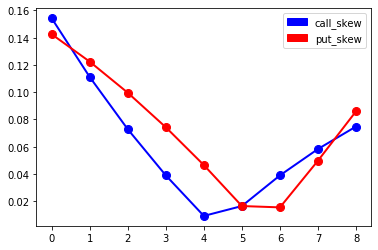

In [15]:
S = 50 #market price
sigma_release = 0.3 #NEWS FORECAST SIGMA
sigma = 0.2 #the volatility in the Wiener Process of the dynamic of the underlying

imp_vol_mp(S, sigma_release)

This demonstrates that there may be mispricings between individual puts and calls at the same strike as their skew curves which represent different levels of implied volatility through strikes are different.

It is intuitive that at a particular strike that the implied volatilty there should be the same because the pricing of possibility of execution at that strike require the same level of fluctation of the underlying whether it be a call or a put.

Although this algorithm executes trades relative to the forecast realized volatility in the release we can see there would present opportunities to arb individual options at particular strikes but hopefully all of these market opportunities are made use of in our put call parity algorithm

## Delta Limits

We need to have a parameter which allows us to specify the maximum magnitude of delta which we are willing to take. An example in the documentation is given as 5000.

Hence, the ultimate goal is to stay delta neutral and only take vega positions. However in practice in a dynamic market this is impossible to achieve perfectly but we can get close to maintaining this.

We will be able to achieve this through a combination of the puts calls and equity positions.

However there are limits on each of these instruments too.

Gross/Net limit of shares is 50,000
Gross options limit is 2,500
Net options limit is 1,000

This means that we can only delta hedge with stocks up to a limit of 50,000 and each option position is representative of 100 contracts.

In [16]:
def delta(S, K, T, r, sigma, option = 'call'):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = si.norm.cdf(d1, 0.0, 1.0)
    if option == 'put':
        result = -si.norm.cdf(-d1, 0.0, 1.0)
        
    return result

In [18]:
import tkinter as tk

In [19]:
class Application(tk.Frame):
    def __init__(self, master=None):
        tk.Frame.__init__(self, master)
        self.pack()
        self.createWidgets()

    def createWidgets(self):
        self.hi_there = tk.Button(self)
        self.hi_there["text"] = "Hello World\n(click me)"
        self.hi_there["command"] = self.say_hi
        self.hi_there.pack(side="top")

        self.QUIT = tk.Button(self, text="QUIT", fg="red",
                                            command=root.destroy)
        self.QUIT.pack(side="bottom")

    def say_hi(self):
        print("hi there, everyone!")

root = tk.Tk()
app = Application(master=root)
app.mainloop()

hi there, everyone!
hi there, everyone!
hi there, everyone!
hi there, everyone!
hi there, everyone!
